# Movie recommendation with graph neural networks (GNN)

Graph is a natural structure to represent user-movie interactions. In a bipartite graph, there are two types of nodes, one represents users and another one for movies. There are edges between user nodes and movie nodes, which represents the rating of a movie given by a user. Therefore, graph neural networks (GNN) can also be used to do movie recommendation.

In this notebook, I used the MovieLens dataset and tested the GNN models in solving recommendation problems. GNN can be used to solve graph-level, node-level, and edge-level tasks. This is an example of edge-level regression problem. 

I have referred the following link for this notebook.
https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2?usp=sharing

In [123]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load data

I used the small dataset just to demonstrate GNN for recommendation system. 

In [124]:
df = pd.read_csv("small_rating.csv")
df.head()

,Unnamed: 0,userId,movieId,rating
0,19846,156,1,5.0
1,19847,156,2,5.0
2,19851,156,6,4.0
3,19854,156,10,4.0
4,19855,156,11,5.0


Only keep three columns: userId, movieId, and rating.

In [125]:
df = df[['userId', 'movieId', 'rating']]

Check the minimum and maximum for userId and movieId. To keep the data storage as packed as possible, we want to map the IDs to new ones that are continuous integers starting from 0.

In [126]:
df.apply([min, max])

,userId,movieId,rating
min,156,1,0.5
max,138325,58559,5.0


Map to new userId and movieId.

In [127]:
unique_userId = sorted(df['userId'].unique())
unique_movieId = sorted(df['movieId'].unique())
df['new_userId'] = df['userId'].map({v:i for i, v in enumerate(unique_userId)})
df['new_movieId'] = df['movieId'].map({v:i for i, v in enumerate(unique_movieId)})
df.head()

,userId,movieId,rating,new_userId,new_movieId
0,156,1,5.0,0,0
1,156,2,5.0,0,1
2,156,6,4.0,0,2
3,156,10,4.0,0,3
4,156,11,5.0,0,4


In [128]:
df.apply([min, max])

,userId,movieId,rating,new_userId,new_movieId
min,156,1,0.5,0,0
max,138325,58559,5.0,499,199


Now, the new userId is from 0 to 499 and new movie Id is from 0 to 199.

### Data process

I used PyG (torch_geometric) to process data and build the GNN models.

In [129]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

In [130]:
data = HeteroData()

In [131]:
n_users = df['new_userId'].nunique()
n_movies = df['new_movieId'].nunique()

I used one-hot encoded IDs for user and movie features. An alternative option is to use the movie genre as feature vectors for movies.

In [132]:
data['user'].x = torch.eye(n_users)
data['movie'].x = torch.eye(n_movies)
edge_index = torch.LongTensor(df[['new_userId', 'new_movieId']].to_numpy().T)
rating = torch.from_numpy(df['rating'].to_numpy()).to(torch.float)
data['user', 'rate', 'movie'].edge_index = edge_index
data['user', 'rate', 'movie'].edge_label = rating
data = T.ToUndirected()(data)

In [133]:
data

HeteroData(
  user={ x=[500, 500] },
  movie={ x=[200, 200] },
  (user, rate, movie)={
    edge_index=[2, 86516],
    edge_label=[86516]
  },
  (movie, rev_rate, user)={
    edge_index=[2, 86516],
    edge_label=[86516]
  }
)

It's easy to access the edge_index and edge_label data using the string tuple indexing.

In [134]:
data['user', 'rate', 'movie']

{'edge_index': tensor([[  0,   0,   0,  ..., 499, 499, 499],
        [  0,   1,   2,  ..., 197, 198, 199]]), 'edge_label': tensor([5.0000, 5.0000, 4.0000,  ..., 4.5000, 4.5000, 5.0000])}

We are solving an edge-level regression problem. So we separate the dataset into train and validation data by spliting the edges randomly.

In [135]:
train_data, val_data, _ = T.RandomLinkSplit(
    num_val=0.2,
    num_test=0.0,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rate', 'movie')],
    rev_edge_types=[('movie', 'rev_rate', 'user')],
)(data)

In [136]:
train_data, val_data

(HeteroData(
   user={ x=[500, 500] },
   movie={ x=[200, 200] },
   (user, rate, movie)={
     edge_index=[2, 69213],
     edge_label=[69213],
     edge_label_index=[2, 69213]
   },
   (movie, rev_rate, user)={
     edge_index=[2, 69213],
     edge_label=[69213]
   }
 ),
 HeteroData(
   user={ x=[500, 500] },
   movie={ x=[200, 200] },
   (user, rate, movie)={
     edge_index=[2, 69213],
     edge_label=[17303],
     edge_label_index=[2, 17303]
   },
   (movie, rev_rate, user)={
     edge_index=[2, 69213],
     edge_label=[69213]
   }
 ))

### Build and train GNN models

In [137]:
from torch_geometric.nn import GATConv, SAGEConv, GCNConv, TransformerConv, to_hetero

In [138]:
data.metadata()

(['user', 'movie'], [('user', 'rate', 'movie'), ('movie', 'rev_rate', 'user')])

I wanted to compare different message passing layers for Graph Neural Networks. We are working with heterogeneous graph, because we have two types of nodes (user nodes and movie nodes). We have to use `to_hetero` function to convert homogeneous GNN model to heterogeneous GNN model. 

In [139]:
class GANEncoder(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(GANEncoder, self).__init__()
        heads = 4
        self.gatconv1 = GATConv((-1, -1), hidden_dim, heads=heads, add_self_loops=False)
        self.lin1 = torch.nn.LazyLinear(heads * hidden_dim)
        self.gatconv2 = GATConv((-1, -1), out_dim, heads=heads, add_self_loops=False)
        self.lin2 = torch.nn.Linear(heads * hidden_dim, heads * out_dim)
        self.lin3 = torch.nn.Linear(heads * out_dim, out_dim)
    
    def forward(self, x, edge_index):
        x = self.gatconv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.gatconv2(x, edge_index) + self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

class SAGEEncoder(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(SAGEEncoder, self).__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_dim)
        self.conv2 = SAGEConv((-1, -1), out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
    
class TransformerEncoder(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(TransformerEncoder, self).__init__()
        self.conv1 = TransformerConv((-1, -1), hidden_dim)
        self.conv2 = TransformerConv((-1, -1), out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class RatingPredictor(torch.nn.Module):
    def __init__(self, feature_dim):
        super(RatingPredictor, self).__init__()
        self.lin1 = torch.nn.Linear(2 * feature_dim, feature_dim)
        self.lin2 = torch.nn.Linear(feature_dim, 1)
    
    def forward(self, x_dict, edge_label_index):
        row, col = edge_label_index
        inputs = torch.cat([x_dict['user'][row], x_dict['movie'][col]], dim=-1)
        outputs = self.lin1(inputs).relu()
        outputs = self.lin2(outputs)
        return outputs.view(-1)
    
class Model(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim, encoder_type):
        super().__init__()
        encoders = {
            "sage": SAGEEncoder(hidden_dim, out_dim),
            "gan": GANEncoder(hidden_dim, out_dim),
            "transformer": TransformerEncoder(hidden_dim, out_dim)
        }
        self.encoder = encoders[encoder_type]
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.rating_predictor = RatingPredictor(out_dim)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        node_feature_dict = self.encoder(x_dict, edge_index_dict)
        return self.rating_predictor(node_feature_dict, edge_label_index)

Create functions to train the model.

In [140]:
import torch.nn.functional as F
def train_epoch(model, optimizer):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict, train_data['user','rate', 'movie'].edge_label_index)
    target = train_data['user', 'rate', 'movie'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict, data['user', 'rate', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'rate', 'movie'].edge_label
    mse = F.mse_loss(pred, target)
    return float(mse)

def model_train(model, lr=0.01, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        loss = train_epoch(model, optimizer)
        train_mse = test(model, train_data)
        val_mse = test(model, val_data)
        if epoch % 20 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train MSE: {train_mse:.4f}, '
                f'Val MSE: {val_mse:.4f}')
    return loss, train_mse, val_mse


Compared three different models

In [141]:
model_1 = Model(hidden_dim=10, out_dim=10, encoder_type='gan')
model_1

/Users/fuyuanjing/opt/anaconda3/envs/6.86x/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model(
  (encoder): GraphModule(
    (gatconv1): ModuleDict(
      (user__rate__movie): GATConv((-1, -1), 10, heads=4)
      (movie__rev_rate__user): GATConv((-1, -1), 10, heads=4)
    )
    (lin1): ModuleDict(
      (user): LazyLinear(in_features=0, out_features=40, bias=True)
      (movie): LazyLinear(in_features=0, out_features=40, bias=True)
    )
    (gatconv2): ModuleDict(
      (user__rate__movie): GATConv((-1, -1), 10, heads=4)
      (movie__rev_rate__user): GATConv((-1, -1), 10, heads=4)
    )
    (lin2): ModuleDict(
      (user): Linear(in_features=40, out_features=40, bias=True)
      (movie): Linear(in_features=40, out_features=40, bias=True)
    )
    (lin3): ModuleDict(
      (user): Linear(in_features=40, out_features=10, bias=True)
      (movie): Linear(in_features=40, out_features=10, bias=True)
    )
  )
  (rating_predictor): RatingPredictor(
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
  

In [142]:
model_train(model_1, lr=0.005, epochs=500)

Epoch: 001, Loss: 12.4635, Train MSE: 12.1873, Val MSE: 12.2043


Epoch: 021, Loss: 2.5956, Train MSE: 1.8553, Val MSE: 1.8492
Epoch: 041, Loss: 1.1364, Train MSE: 1.0919, Val MSE: 1.0909
Epoch: 061, Loss: 0.8794, Train MSE: 0.8662, Val MSE: 0.8688
Epoch: 081, Loss: 0.7863, Train MSE: 0.7823, Val MSE: 0.7878
Epoch: 101, Loss: 0.7083, Train MSE: 0.7025, Val MSE: 0.7102
Epoch: 121, Loss: 0.6486, Train MSE: 0.6470, Val MSE: 0.6575
Epoch: 141, Loss: 0.6422, Train MSE: 0.6420, Val MSE: 0.6524
Epoch: 161, Loss: 0.6414, Train MSE: 0.6413, Val MSE: 0.6516
Epoch: 181, Loss: 0.6411, Train MSE: 0.6410, Val MSE: 0.6511
Epoch: 201, Loss: 0.6410, Train MSE: 0.6409, Val MSE: 0.6509
Epoch: 221, Loss: 0.6409, Train MSE: 0.6408, Val MSE: 0.6509
Epoch: 241, Loss: 0.6409, Train MSE: 0.6408, Val MSE: 0.6509
Epoch: 261, Loss: 0.6409, Train MSE: 0.6408, Val MSE: 0.6508
Epoch: 281, Loss: 0.6408, Train MSE: 0.6407, Val MSE: 0.6508
Epoch: 301, Loss: 0.6408, Train MSE: 0.6407, Val MSE: 0.6507
Epoch: 321, Loss: 0.6408, Train MSE: 0.6407, Val MSE: 0.6507
Epoch: 341, Loss: 0.6408

(0.6407933831214905, 0.6407012939453125, 0.6506454348564148)

In [143]:
model_2 = Model(hidden_dim=10, out_dim=10, encoder_type='sage')
model_2

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rate__movie): SAGEConv((-1, -1), 10, aggr=mean)
      (movie__rev_rate__user): SAGEConv((-1, -1), 10, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rate__movie): SAGEConv((-1, -1), 10, aggr=mean)
      (movie__rev_rate__user): SAGEConv((-1, -1), 10, aggr=mean)
    )
  )
  (rating_predictor): RatingPredictor(
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [144]:
model_train(model_2, lr=0.005, epochs=500)

Epoch: 001, Loss: 14.0591, Train MSE: 13.7719, Val MSE: 13.7903
Epoch: 021, Loss: 11.7855, Train MSE: 11.6768, Val MSE: 11.6934
Epoch: 041, Loss: 4.3191, Train MSE: 3.6540, Val MSE: 3.6612
Epoch: 061, Loss: 0.9662, Train MSE: 0.9616, Val MSE: 0.9596
Epoch: 081, Loss: 0.9372, Train MSE: 0.9445, Val MSE: 0.9422
Epoch: 101, Loss: 0.8834, Train MSE: 0.8796, Val MSE: 0.8795
Epoch: 121, Loss: 0.8341, Train MSE: 0.8321, Val MSE: 0.8326
Epoch: 141, Loss: 0.7930, Train MSE: 0.7910, Val MSE: 0.7925
Epoch: 161, Loss: 0.7538, Train MSE: 0.7519, Val MSE: 0.7548
Epoch: 181, Loss: 0.7193, Train MSE: 0.7177, Val MSE: 0.7220
Epoch: 201, Loss: 0.6918, Train MSE: 0.6906, Val MSE: 0.6964
Epoch: 221, Loss: 0.6718, Train MSE: 0.6711, Val MSE: 0.6784
Epoch: 241, Loss: 0.6603, Train MSE: 0.6599, Val MSE: 0.6686
Epoch: 261, Loss: 0.6548, Train MSE: 0.6546, Val MSE: 0.6642
Epoch: 281, Loss: 0.6520, Train MSE: 0.6518, Val MSE: 0.6620
Epoch: 301, Loss: 0.6503, Train MSE: 0.6502, Val MSE: 0.6605
Epoch: 321, Loss: 

(0.644902765750885, 0.6447854042053223, 0.6554559469223022)

In [145]:
model_3 = Model(hidden_dim=10, out_dim=10, encoder_type='transformer')
model_3

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rate__movie): TransformerConv((-1, -1), 10, heads=1)
      (movie__rev_rate__user): TransformerConv((-1, -1), 10, heads=1)
    )
    (conv2): ModuleDict(
      (user__rate__movie): TransformerConv((-1, -1), 10, heads=1)
      (movie__rev_rate__user): TransformerConv((-1, -1), 10, heads=1)
    )
  )
  (rating_predictor): RatingPredictor(
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [146]:
model_train(model_3, lr=0.005, epochs=500)

Epoch: 001, Loss: 15.0833, Train MSE: 14.3441, Val MSE: 14.3630
Epoch: 021, Loss: 8.6020, Train MSE: 7.8433, Val MSE: 7.8556
Epoch: 041, Loss: 1.3962, Train MSE: 1.1740, Val MSE: 1.1700
Epoch: 061, Loss: 0.9083, Train MSE: 0.9169, Val MSE: 0.9166
Epoch: 081, Loss: 0.8706, Train MSE: 0.8653, Val MSE: 0.8675
Epoch: 101, Loss: 0.8067, Train MSE: 0.8046, Val MSE: 0.8083
Epoch: 121, Loss: 0.7584, Train MSE: 0.7560, Val MSE: 0.7614
Epoch: 141, Loss: 0.7119, Train MSE: 0.7096, Val MSE: 0.7167
Epoch: 161, Loss: 0.6706, Train MSE: 0.6688, Val MSE: 0.6775
Epoch: 181, Loss: 0.6479, Train MSE: 0.6476, Val MSE: 0.6573
Epoch: 201, Loss: 0.6445, Train MSE: 0.6443, Val MSE: 0.6543
Epoch: 221, Loss: 0.6430, Train MSE: 0.6428, Val MSE: 0.6528
Epoch: 241, Loss: 0.6424, Train MSE: 0.6422, Val MSE: 0.6523
Epoch: 261, Loss: 0.6421, Train MSE: 0.6420, Val MSE: 0.6521
Epoch: 281, Loss: 0.6419, Train MSE: 0.6418, Val MSE: 0.6519
Epoch: 301, Loss: 0.6418, Train MSE: 0.6417, Val MSE: 0.6518
Epoch: 321, Loss: 0.6

(0.641376793384552, 0.6412789821624756, 0.6512827277183533)

### Evaluate the model

All three models have almost the same performance in terms of validation MSE. I compared the predicted rating with actural rating for the validation dataset.

In [147]:
val_data

HeteroData(
  user={ x=[500, 500] },
  movie={ x=[200, 200] },
  (user, rate, movie)={
    edge_index=[2, 69213],
    edge_label=[17303],
    edge_label_index=[2, 17303]
  },
  (movie, rev_rate, user)={
    edge_index=[2, 69213],
    edge_label=[69213]
  }
)

In [148]:
val_target = val_data['user', 'rate', 'movie'].edge_label
val_target

tensor([4., 3., 4.,  ..., 3., 3., 4.])

In [149]:
val_pred = model_1(val_data.x_dict, val_data.edge_index_dict, val_data['user', 'rate', 'movie'].edge_label_index).detach()
val_pred

tensor([4.2005, 2.8935, 3.6712,  ..., 3.7258, 4.0368, 3.2688])

In [150]:
print(f"the MSE of the validation predication is {F.mse_loss(val_pred, val_target)}")
print(f"the RMSE of the validation prediction is {F.mse_loss(val_pred, val_target).sqrt()}")

the MSE of the validation predication is 0.6507750153541565
the RMSE of the validation prediction is 0.8067062497138977


In [151]:
import matplotlib.pyplot as plt

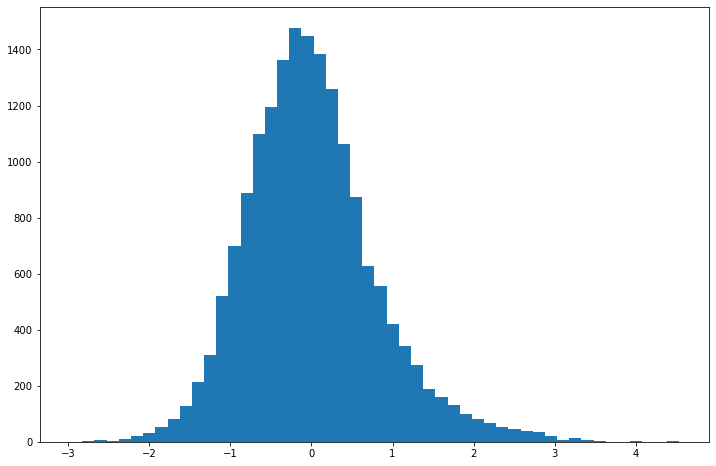

In [152]:
residue = (val_pred - val_target).numpy()
plt.figure(figsize=(12,8))
plt.hist(residue, bins=50)
plt.show()

We can see the distribution of residues is symetric and most of the errors are within -1 and +1.

### Make recommendations

In [153]:
# create a function to generate all possible edge index for a user
def all_edges(userId):
    edge_index = np.array([[userId]*n_movies, np.arange(n_movies)])
    return torch.LongTensor(edge_index)

def rate_all_movies_by_user(model, userId):
    edge_label_index = all_edges(userId)
    pred = model(data.x_dict, data.edge_index_dict, edge_label_index)
    pred = pred.detach().numpy()
    df = {
        'new_userId': [userId] * n_movies,
        'new_movieId': np.arange(n_movies),
        'rating_pred': pred,
    }
    return pd.DataFrame(df)

Predict the ratings for all movies given by a user.

In [154]:
new_userId = 400
pred_df = rate_all_movies_by_user(model_1, new_userId)
pred_df

,new_userId,new_movieId,rating_pred
0,400,0,3.700058
1,400,1,2.598008
2,400,2,3.418951
3,400,3,2.915419
4,400,4,3.071210
...,...,...,...
195,400,195,3.722353
196,400,196,3.506878
197,400,197,3.665986
198,400,198,3.615706


In [155]:
df_user = df[df['new_userId']==new_userId]
df_user

,userId,movieId,rating,new_userId,new_movieId
69152,111549,1,3.0,400,0
69153,111549,2,3.0,400,1
69154,111549,10,3.0,400,3
69155,111549,11,3.0,400,4
69156,111549,17,4.0,400,6
...,...,...,...,...,...
69306,111549,7361,4.5,400,195
69307,111549,7438,3.0,400,196
69308,111549,8961,3.5,400,197
69309,111549,33794,3.5,400,198


In [156]:
print(f"This user has already rated {len(df_user)} movies. We should recommend movies from those not watched yet.")

This user has already rated 159 movies. We should recommend movies from those not watched yet.


Select the movies that have not been watched.

In [157]:
recommend_df = pred_df[~pred_df['new_movieId'].isin(df_user.new_movieId)]
# oder the predicted rating from highest to lowest
recommend_df = recommend_df.sort_values(by='rating_pred', ascending=False)
recommend_df.head(10)

,new_userId,new_movieId,rating_pred
60,400,60,3.958329
97,400,97,3.916569
92,400,92,3.769733
34,400,34,3.764854
143,400,143,3.704622
148,400,148,3.573842
19,400,19,3.564238
180,400,180,3.529225
168,400,168,3.523056
5,400,5,3.457252
